In [1]:
import os
import sqlite3
import pandas as pd
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import pickle
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sab
from sklearn.model_selection import StratifiedKFold

Загружаем базу данных.

In [2]:
db_name='../../main_database.sqlite'     
sqlite_db=sqlite3.connect(db_name)
dataBase = pd.read_sql('SELECT * FROM functions', sqlite_db)
sqlite_db.close()

In [3]:
print(dataBase.head())

   id        name  address compiler options libname  \
0   1  .init_proc    12288      gcc     -O0    gzip   
1   2    sub_3020    12320      gcc     -O0    gzip   
2   3    sub_3030    12336      gcc     -O0    gzip   
3   4    sub_3040    12352      gcc     -O0    gzip   
4   5    sub_3050    12368      gcc     -O0    gzip   

                                            assembly  
0  endbr64; _init\nsub     rsp, 8\nmov     rax, c...  
1     push    cs:qword_18D58\nbnd jmp cs:qword_18D60  
2               endbr64\npush    0\nbnd jmp sub_3020  
3               endbr64\npush    1\nbnd jmp sub_3020  
4               endbr64\npush    2\nbnd jmp sub_3020  


In [4]:
print(dataBase.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62339 entries, 0 to 62338
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        62339 non-null  int64 
 1   name      62339 non-null  object
 2   address   62339 non-null  int64 
 3   compiler  62339 non-null  object
 4   options   62339 non-null  object
 5   libname   62339 non-null  object
 6   assembly  62339 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.3+ MB
None


In [5]:
dbCountObjects = dataBase['assembly'].count()   # Количество объектов в базе
dbCountObjects

62339

# Делим набор данных и готовим к добавлению в словарь

In [6]:
assembly = pd.DataFrame(dataBase['assembly'], dtype='<U14')['assembly']
compiler = pd.DataFrame(dataBase['compiler'], dtype='<U14')['compiler']

In [7]:
with tf.device('/GPU:0'):
    # Делим набор данных
    assembly_train = assembly[:40000]
    assembly_test = assembly[40000:]
    compiler_train = compiler[:40000]
    compiler_test = compiler[40000:]
    #assembly_train, assembly_test, compiler_train, compiler_test = train_test_split(assembly, compiler, test_size=0.33, shuffle=True)
    
    #Заченяем числа всех систем счисления на "digit"
    assembly_train = assembly_train.apply(lambda element: re.sub("\d[A-Fa-f0-9]*[dhbqo]?", "digit", element)) 
    assembly_test = assembly_test.apply(lambda element: re.sub("\d[A-Fa-f0-9]*[dhbqo]?", "digit", element)) 
    #Заченяем "loc_*" на "loc"
    assembly_train = assembly_train.apply(lambda element: re.sub("loc_[\w]*", "loc", element))
    assembly_test = assembly_test.apply(lambda element: re.sub("loc_[\w]*", "loc", element))
    #Заченяем "var_*" на "var"
    assembly_train = assembly_train.apply(lambda element: re.sub("var_[\w]*", "digit", element))
    assembly_test = assembly_test.apply(lambda element: re.sub("var_[\w]*", "digit", element))

    #Заченяем "gcc" на 1, "clang" на 0
    compiler_train = compiler_train.apply(lambda element: int(re.sub("gcc", "1", element)) if element=="gcc" else int(re.sub("clang", "0", element)))    
    compiler_test = compiler_test.apply(lambda element: int(re.sub("gcc", "1", element)) if element=="gcc" else int(re.sub("clang", "0", element)))    

# Создаём словарь из набора слов ассемблер-функций

In [9]:
maxDim = 10800  # Размер словаря (общее кол-во токенов)

In [ ]:
# Tokenizer убирает символы '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', а разделителем слов является пробел
tokenizer = Tokenizer(num_words= maxDim, split=' ',char_level=False, oov_token='<OOV>')

#if (os.path.exists('.\\TokenizedDictionary') == True):   # Если словарь уже создан - загружаем его
#    with open('.\\TokenizedDictionary', 'rb') as handle:
#        tokenizer = pickle.load(handle)
#else:    # Иначе - заполняем словарь
with tf.device('/GPU:0'):
        i = 0
        for assembly in assembly_train:
            tokenizer.fit_on_texts([assembly])    #Добавляем слова в словарь
            i += 1
            if (i % 1000 == 0):
                print(i)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [56]:
with open('TokenizedDictionary', 'wb') as handle:               # Сохранение словаря
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
word_indexes = tokenizer.word_index
print(word_indexes)

{'<OOV>': 1, 'digit': 2, 'mov': 3, 'loc': 4, 'rax': 5, 'rdigit': 6, 'rbp': 7, 'eax': 8, 'rdi': 9, 'ptr': 10, 'short': 11, 'call': 12, 'rsp': 13, 'cmp': 14, 'rbx': 15, 'jz': 16, 'rcx': 17, 'rdx': 18, 'jmp': 19, 'test': 20, 'rsi': 21, 'lea': 22, 'ecx': 23, 'edx': 24, 'add': 25, 'push': 26, 'jnz': 27, 'xor': 28, 'pop': 29, 'esi': 30, 'xmmdigit': 31, 'dword': 32, 'qword': 33, "'": 34, 'cs': 35, 'sub': 36, 'edi': 37, 'byte': 38, 'al': 39, 'movzx': 40, 'retn': 41, 'ctxt': 42, 'ebx': 43, 'ebp': 44, 's': 45, 'int': 46, 'and': 47, 'movsxd': 48, 'cl': 49, 'n': 50, 'endbrdigit': 51, 'jumptable': 52, 'case': 53, 'xmmword': 54, 'word': 55, 'or': 56, 'dl': 57, 'shl': 58, 'ja': 59, 'nop': 60, 'ds': 61, 'jle': 62, 'error': 63, 'movups': 64, 'cur': 65, 'xmlfree': 66, 'name': 67, 'offset': 68, 'jbe': 69, 'xmlstrequal': 70, 'jnb': 71, 'strdigit': 72, 'jg': 73, 'src': 74, 'ax': 75, 'node': 76, 'shr': 77, 'format': 78, 'cases': 79, 'jb': 80, 'buf': 81, 'jge': 82, 'intdigit': 83, 'default': 84, 'arg': 85, '

# Подготовка данных для обучения:

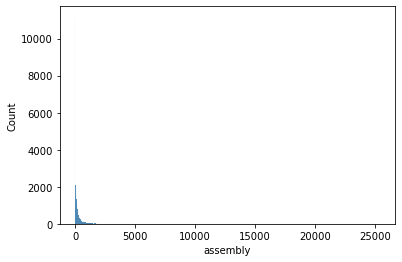

In [11]:
# Смотрим на длины токенизированных ассемблеров 
length = assembly_train.apply(lambda element: len(tokenizer.texts_to_sequences([element])[0]))
a = sab.histplot(length)
    

In [12]:
minLen = 10     # Мин. кол-во токенов ассемблерной функции
maxLen = 200   # Макс. кол-во токенов 

In [13]:
def prepareDataForLearning(dataX, dataY):
    # переводим ассемблер в токены
    tokenizedAssemb = dataX.apply(lambda element: tokenizer.texts_to_sequences([element])[0])
    # отсекаем маленькие функции
    tokenizedAssemb = tokenizedAssemb.apply(lambda element: 0 if len(element) < minLen else element)
    tokenizedAssemb = tokenizedAssemb.drop(tokenizedAssemb[tokenizedAssemb == 0].index)
    # обрезаем большие функции
    tokenizedAssemb = tokenizedAssemb.apply(lambda element: element[:maxLen])
    
    # Записываем данные в numpy массивы
    resultX = np.zeros((tokenizedAssemb.shape[0], maxLen))
    resultY = np.zeros((tokenizedAssemb.shape[0]))
    counter = 0
    for i in tokenizedAssemb.index:
        resultX[counter][:len(tokenizedAssemb[i])] = tokenizedAssemb[i]
        resultY[counter] = dataY[i]
        counter += 1
    # перемешиваем набор данных
    shuffled_indexes = list(range(0, tokenizedAssemb.shape[0]))
    random.shuffle(shuffled_indexes)
    # удаляем временную переменную
    del tokenizedAssemb
    gc.collect()
    return resultX[shuffled_indexes], resultY[shuffled_indexes]

In [14]:
with tf.device('/GPU:0'):
    x_train, y_train = prepareDataForLearning(assembly_train, compiler_train)
    x_test, y_test = prepareDataForLearning(assembly_test, compiler_test)

In [15]:
print(x_train.shape)
print(y_train.shape)

(30672, 200)
(30672,)


# Проектирование модели нейронной сети:

In [20]:
def initializeModel(model):
    a1 = Embedding(
        input_dim=maxDim, output_dim=100, input_length=maxLen)
    a2 = Bidirectional(LSTM(10, input_shape=(maxLen, 100)))
    a3 = Dense(1, activation='sigmoid')
    
    model.add(a1)          
    model.add(a2)          
    model.add(a3)
    
    optim = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optim, loss='binary_crossentropy',metrics=['accuracy'])

In [81]:
model_without_KFold = Sequential()
initializeModel(model_without_KFold)

In [63]:
# загрузка сохранённой модели
model_without_KFold = keras.models.load_model('.\\model')   

In [82]:
model_without_KFold.summary()    # Embbeding: выход: (batch, assembLeght(Tokenized)=10000, features=30)
                   # Вход LSTM: (batch, timesteps, features): в роли timesteps - токенизированные слова ассемблера;
                   # в роли features - embedding-вектор, описывающий токенизированное слово

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 100)          1080000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 20)                8880      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 1,088,901
Trainable params: 1,088,901
Non-trainable params: 0
_________________________________________________________________


# Обучение:

In [33]:
epochsCount = 20
with_KFold = False

1) Обычный вариант

In [83]:
if (with_KFold == False):
    trainCount = int(len(x_train) * 0.8)
    with tf.device('/GPU:0'):
        history = model_without_KFold.fit(
            x_train[:trainCount], 
            y_train[:trainCount],
            batch_size=800, 
            epochs=epochsCount, 
            validation_data=(x_train[trainCount:], y_train[trainCount:]),
            callbacks=
                [EarlyStopping(monitor='loss', min_delta=0.001, mode='min', patience=2),
                 #ModelCheckpoint(filepath='.\\model'),
                 ReduceLROnPlateau(monitor="loss", patience=1, min_lr=0.0001)])

Epoch 1/20
31/31 [==============================] - 10s 169ms/step - loss: 0.4169 - accuracy: 0.8196 - val_loss: 0.2452 - val_accuracy: 0.9037
Epoch 2/20
31/31 [==============================] - 4s 135ms/step - loss: 0.1909 - accuracy: 0.9251 - val_loss: 0.1826 - val_accuracy: 0.9216
Epoch 3/20
31/31 [==============================] - 4s 144ms/step - loss: 0.1428 - accuracy: 0.9390 - val_loss: 0.1642 - val_accuracy: 0.9244
Epoch 4/20
31/31 [==============================] - 4s 144ms/step - loss: 0.1218 - accuracy: 0.9467 - val_loss: 0.1579 - val_accuracy: 0.9353
Epoch 5/20
31/31 [==============================] - 4s 142ms/step - loss: 0.1045 - accuracy: 0.9512 - val_loss: 0.1500 - val_accuracy: 0.9271
Epoch 6/20
31/31 [==============================] - 4s 142ms/step - loss: 0.1032 - accuracy: 0.9539 - val_loss: 0.1535 - val_accuracy: 0.9333
Epoch 7/20
31/31 [==============================] - 5s 148ms/step - loss: 0.0898 - accuracy: 0.9586 - val_loss: 0.1512 - val_accuracy: 0.9374
Epoch

2) Вариант с KFold

In [27]:
if (with_KFold):
    historyList = []
    bestTestAccuracy = 0
    splitCount = 6
    kfold = StratifiedKFold(n_splits=splitCount, shuffle=False)
    for train, valid in kfold.split(x_train, y_train):
        with tf.device('/GPU:0'):
            #Инициализируем модель
            model = Sequential()
            initializeModel(model)
            # Обучаем
            historyList.append( model.fit(
                x_train[train], 
                y_train[train],
                batch_size=800, 
                epochs=epochsCount, 
                validation_data=(x_train[valid], y_train[valid]),
                callbacks=
                    [EarlyStopping(monitor='loss', min_delta=0.001, mode='min', patience=2),
                     #ModelCheckpoint(filepath='.\\model'),
                     ReduceLROnPlateau(monitor="loss", patience=1, min_lr=0.0001)]))
            #Проверяем лучше ли предыдущих текущая метрика на тестовом датасете (если лучше, то сохраняем модель)
            loss_metric_test = model.evaluate(x_test,y_test,batch_size=800)
            if ( loss_metric_test[-1] > bestTestAccuracy):
                bestTestAccuracy = loss_metric_test[-1]
                bestHistory = historyList[-1]
                best_model_with_KFold = model
                model.save('.\\model')

Epoch 1/20
32/32 [==============================] - 42s 172ms/step - loss: 0.3833 - accuracy: 0.8446 - val_loss: 0.2175 - val_accuracy: 0.9173
Epoch 2/20
32/32 [==============================] - 4s 129ms/step - loss: 0.1785 - accuracy: 0.9322 - val_loss: 0.1666 - val_accuracy: 0.9354
Epoch 3/20
32/32 [==============================] - 4s 136ms/step - loss: 0.1507 - accuracy: 0.9398 - val_loss: 0.1515 - val_accuracy: 0.9382
Epoch 4/20
32/32 [==============================] - 4s 134ms/step - loss: 0.1332 - accuracy: 0.9420 - val_loss: 0.1432 - val_accuracy: 0.9370
Epoch 5/20
32/32 [==============================] - 4s 140ms/step - loss: 0.1164 - accuracy: 0.9463 - val_loss: 0.1377 - val_accuracy: 0.9386
Epoch 6/20
32/32 [==============================] - 4s 140ms/step - loss: 0.1050 - accuracy: 0.9511 - val_loss: 0.1327 - val_accuracy: 0.9397
Epoch 7/20
32/32 [==============================] - 5s 142ms/step - loss: 0.0930 - accuracy: 0.9567 - val_loss: 0.1281 - val_accuracy: 0.9415
Epoch

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


Epoch 1/20
32/32 [==============================] - 12s 186ms/step - loss: 0.4028 - accuracy: 0.8333 - val_loss: 0.2664 - val_accuracy: 0.8957
Epoch 2/20
32/32 [==============================] - 4s 140ms/step - loss: 0.2277 - accuracy: 0.9142 - val_loss: 0.1973 - val_accuracy: 0.9229
Epoch 3/20
32/32 [==============================] - 4s 140ms/step - loss: 0.1700 - accuracy: 0.9326 - val_loss: 0.1632 - val_accuracy: 0.9304
Epoch 4/20
32/32 [==============================] - 5s 143ms/step - loss: 0.1371 - accuracy: 0.9446 - val_loss: 0.1597 - val_accuracy: 0.9362
Epoch 5/20
32/32 [==============================] - 5s 146ms/step - loss: 0.1254 - accuracy: 0.9477 - val_loss: 0.1685 - val_accuracy: 0.9362
Epoch 6/20
32/32 [==============================] - 5s 145ms/step - loss: 0.1140 - accuracy: 0.9528 - val_loss: 0.1572 - val_accuracy: 0.9304
Epoch 7/20
32/32 [==============================] - 5s 145ms/step - loss: 0.1045 - accuracy: 0.9554 - val_loss: 0.1498 - val_accuracy: 0.9372
Epoch

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


Epoch 1/20
32/32 [==============================] - 16s 194ms/step - loss: 0.4042 - accuracy: 0.8268 - val_loss: 0.2300 - val_accuracy: 0.9149
Epoch 2/20
32/32 [==============================] - 4s 140ms/step - loss: 0.1914 - accuracy: 0.9252 - val_loss: 0.1726 - val_accuracy: 0.9309
Epoch 3/20
32/32 [==============================] - 5s 145ms/step - loss: 0.1574 - accuracy: 0.9334 - val_loss: 0.1529 - val_accuracy: 0.9374
Epoch 4/20
32/32 [==============================] - 5s 146ms/step - loss: 0.1336 - accuracy: 0.9432 - val_loss: 0.1394 - val_accuracy: 0.9376
Epoch 5/20
32/32 [==============================] - 5s 146ms/step - loss: 0.1137 - accuracy: 0.9483 - val_loss: 0.1313 - val_accuracy: 0.9401
Epoch 6/20
32/32 [==============================] - 5s 146ms/step - loss: 0.1019 - accuracy: 0.9538 - val_loss: 0.1246 - val_accuracy: 0.9452
Epoch 7/20
32/32 [==============================] - 5s 148ms/step - loss: 0.0899 - accuracy: 0.9583 - val_loss: 0.1273 - val_accuracy: 0.9405
Epoch

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


Epoch 1/20
32/32 [==============================] - 14s 194ms/step - loss: 0.3875 - accuracy: 0.8433 - val_loss: 0.2230 - val_accuracy: 0.9178
Epoch 2/20
32/32 [==============================] - 5s 143ms/step - loss: 0.1803 - accuracy: 0.9311 - val_loss: 0.1885 - val_accuracy: 0.9229
Epoch 3/20
32/32 [==============================] - 5s 146ms/step - loss: 0.1510 - accuracy: 0.9418 - val_loss: 0.1573 - val_accuracy: 0.9382
Epoch 4/20
32/32 [==============================] - 5s 146ms/step - loss: 0.1391 - accuracy: 0.9439 - val_loss: 0.1571 - val_accuracy: 0.9354
Epoch 5/20
32/32 [==============================] - 5s 147ms/step - loss: 0.1239 - accuracy: 0.9484 - val_loss: 0.1542 - val_accuracy: 0.9321
Epoch 6/20
32/32 [==============================] - 5s 146ms/step - loss: 0.1139 - accuracy: 0.9528 - val_loss: 0.1512 - val_accuracy: 0.9341
Epoch 7/20
32/32 [==============================] - 5s 146ms/step - loss: 0.0972 - accuracy: 0.9580 - val_loss: 0.1509 - val_accuracy: 0.9397
Epoch

In [ ]:
model.save('.\\model')

In [99]:
history.history  # Здесь храняться метрики тренировочного и валидационного датасетов, полученные при обучении без KFold

{'loss': [0.3213542401790619,
  0.1570066213607788,
  0.1427256017923355,
  0.11761046200990677,
  0.10237225890159607,
  0.0924067273736,
  0.08322472870349884,
  0.0827050656080246,
  0.06964972615242004,
  0.06924832612276077,
  0.06363631039857864,
  0.06058318167924881,
  0.05923571065068245,
  0.05915225297212601,
  0.04965541511774063,
  0.04709124192595482,
  0.045904580503702164,
  0.0449710413813591,
  0.04439886286854744,
  0.04360182583332062],
 'accuracy': [0.8770835995674133,
  0.9373191595077515,
  0.9411908388137817,
  0.9496271014213562,
  0.9539063572883606,
  0.9572482109069824,
  0.9609569311141968,
  0.9612421989440918,
  0.9673554301261902,
  0.9672738909721375,
  0.9687818288803101,
  0.9720829725265503,
  0.9715939164161682,
  0.971960723400116,
  0.9757509231567383,
  0.9761584401130676,
  0.9767290353775024,
  0.9770143032073975,
  0.9773403406143188,
  0.9772180914878845],
 'val_loss': [0.1707845777273178,
  0.16565564274787903,
  0.14275652170181274,
  0.149

# Значения метрик на тестовом наборе данных

Без KFold

In [84]:
with tf.device('/GPU:0'):
    loss_metric_test = model_without_KFold.evaluate(x_test,y_test,batch_size=800)

26/26 [==============================] - 1s 46ms/step - loss: 0.1026 - accuracy: 0.9681


In [80]:
loss_metric_test[1]

0.9871131181716919

С KFold

In [79]:
print('Accuracy:', bestTestAccuracy)

Accuracy: 0.9871131181716919


# Графики:

In [85]:
X = range(1,epochsCount + 1)

### Обучение без KFold

1) Функция потерь и accuracy

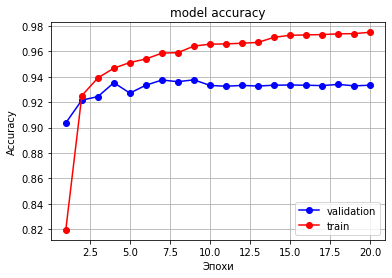

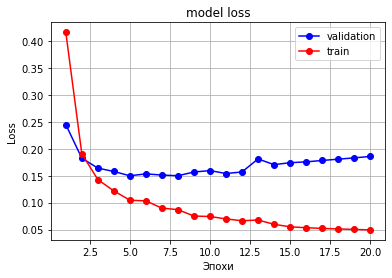

In [89]:
leng = len(history.history['val_accuracy'])
fig, ax1 = plt.subplots(1, 1)
ax1.plot(X[:leng], history.history['val_accuracy'], 'o-', color='blue', label='validation')
ax1.plot(X[:leng], history.history['accuracy'], 'o-', color='red', label='train')
ax1.grid()
ax1.set_xlabel('Эпохи')
ax1.set_ylabel('Accuracy')
ax1.legend()
plt.title('model accuracy')
plt.show()

fig, ax2 = plt.subplots(1, 1)
ax2.plot(X[:leng], history.history['val_loss'], 'o-', color='blue', label='validation')
ax2.plot(X[:leng], history.history['loss'], 'o-', color='red', label='train')
ax2.grid()
ax2.set_xlabel('Эпохи')
ax2.set_ylabel('Loss')
ax2.legend()
plt.title('model loss')
plt.show()

2) Матрица ошибок

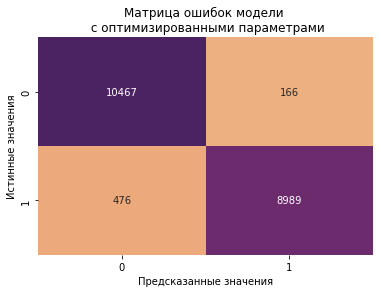

In [87]:
prediction_matrix = confusion_matrix(y_test, model_without_KFold.predict(x_test).round())
sab.heatmap(prediction_matrix, annot=True, fmt='.7g', cmap='flare', cbar=False)
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок модели \n с оптимизированными параметрами')
plt.show()

Графики в другом виде

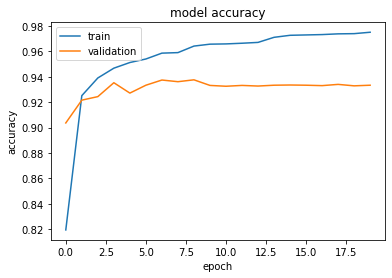

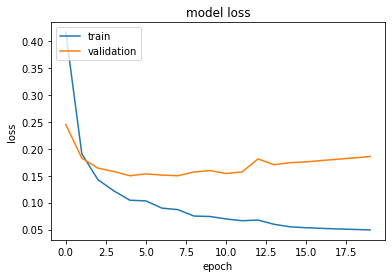

In [90]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Обучение с использованием KFold

1) Функция потерь и accuracy

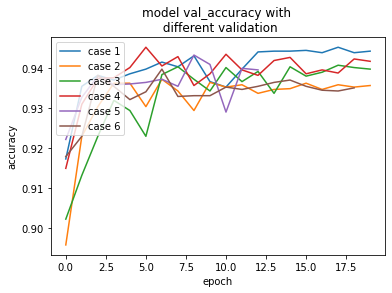

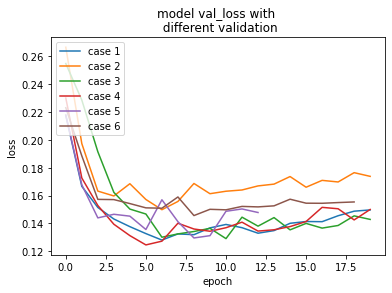

In [59]:
for i in range(splitCount):
    plt.plot(historyList[i].history['val_accuracy'])
plt.title('model val_accuracy with \n different validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['case 1', 'case 2','case 3','case 4','case 5','case 6'], loc='upper left')
plt.show()
# summarize history for loss
for i in range(splitCount):
    plt.plot(historyList[i].history['val_loss'])
plt.title('model val_loss with \n different validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['case 1', 'case 2','case 3','case 4','case 5','case 6'], loc='upper left')
plt.show()

2) Матрица ошибок

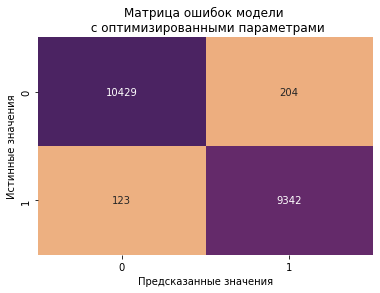

In [77]:
prediction_matrix = confusion_matrix(y_test, best_model_with_KFold.predict(x_test).round())
sab.heatmap(prediction_matrix, annot=True, fmt='.7g', cmap='flare', cbar=False)
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок модели \n с оптимизированными параметрами')
plt.show()

### Сравнение обучения с использованием KFold и без

При обучении с использованием KFold был выбран лучший из вариантов деления датасета

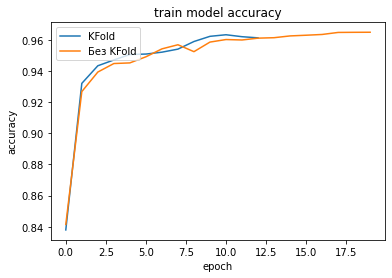

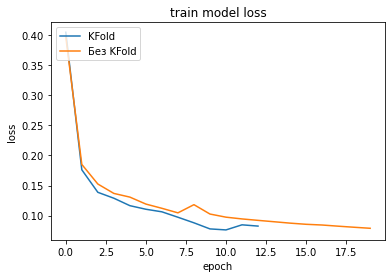

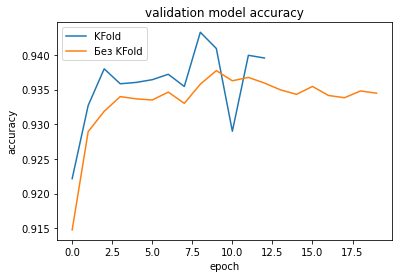

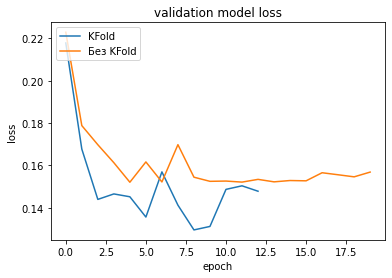

In [62]:
plt.plot(bestHistory.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.title('train model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['KFold', 'Без KFold'], loc='upper left')
plt.show()

plt.plot(bestHistory.history['loss'])
plt.plot(history.history['loss'])
plt.title('train model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['KFold', 'Без KFold'], loc='upper left')
plt.show()

plt.plot(bestHistory.history['val_accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('validation model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['KFold', 'Без KFold'], loc='upper left')
plt.show()

plt.plot(bestHistory.history['val_loss'])
plt.plot(history.history['val_loss'])
plt.title('validation model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['KFold', 'Без KFold'], loc='upper left')
plt.show()